# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

In [1]:
import common_utils

C:\Users\nsupr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.Define the model class.

In [6]:
"""
to build: 
- 3 hidden layers of 128 nuerons each with ReLU activation
- 1 output layer with sigmoid activation function
- apply dropout of prob 0.2 to each of the hidden layers
"""

class MLP(nn.Module):
    # initialize the model parameters
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__() # call the parent class constructor
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            
            # 1st hidden layer - Input layer
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # First Hidden Layer -> Second hidden layer
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Second hidden layer -> Third hidden layer
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Third hidden layer -> Output layer with sigmoid activation function
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )
        
        

    # YOUR CODE HERE
    def forward(self, x):
        # get the output by passing the input through the mlp_stack
        return self.mlp_stack(x)

#### Divide the dataset into a 75:25 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

2.Split the dataset and do preprocessing.

In [8]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # YOUR CODE HERE
    """
    columns_to_drop = filename, label because it contains the required output: neg/pos
    because we don't want to give the model access to the information it is trying to predict
    training:testing is 7:3 so test_size = 0.3
    split_dataset function returns: df_train2, y_train2, df_test2, y_test2
    assumption: no random_state specified hence is set random_state = 0
    """
    
    X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], 0.3, 0)
    
    #return requires scaled X_train (X_train_scaled) and X_test values (X_test_scaled)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

"""
Explanation on why we used StandardScaler for preprocessing and why it's appropriate:

Utilizing the StandardScaler for preprocessing is appropriate for our neural network model, especially when the dataset contains diverse features with different scales, like in the 
National Speech Corpus. Neural networks tend to perform optimally when input data is standardized. Features with larger scales can disproportionately impact the training, causing slower 
convergence. With StandardScaler, all features are standardized to have a mean of 0 and a standard deviation of 1. This ensures that each feature has a consistent influence during 
training, leading to faster and more stable convergence. Given the diverse features in our project, such as MFCCs and chromagrams, this standardization is crucial for balanced training.
"""

In [11]:
# read data
df = pd.read_csv('simplified.csv')
df

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12052,app_3057_4113_phnd_pos_0022.wav,86.132812,1605,160.500000,0.549566,0.078633,0.438854,0.078327,0.258500,0.016511,...,-12.779257,67.892044,3.546391,49.891026,-3.597707,70.953079,-2.672421,62.369473,-3.812236,47.410625
12053,app_3057_4113_phnd_pos_0023.wav,184.570312,3037,168.722222,0.584372,0.074350,0.478900,0.078894,0.258216,0.016658,...,-9.979423,63.430107,3.869859,52.517521,-1.637068,59.811417,-3.041467,55.640205,-5.101839,43.080894
12054,app_3057_4113_phnd_pos_0024.wav,143.554688,1549,129.083333,0.541845,0.088258,0.441677,0.080670,0.261484,0.014959,...,-11.238145,79.961853,3.689087,68.597672,-1.665412,70.761398,0.218386,86.220604,-4.678007,85.629585
12055,app_3057_4113_phnd_pos_0025.wav,143.554688,8820,284.516129,0.532886,0.089102,0.469113,0.077342,0.265298,0.012950,...,-10.302938,80.636742,2.619849,63.592182,-0.559597,62.905022,0.256377,56.687534,-3.086725,62.594326


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12057 entries, 0 to 12056
Data columns (total 78 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   filename             12057 non-null  object 
 1   tempo                12057 non-null  float64
 2   total_beats          12057 non-null  int64  
 3   average_beats        12057 non-null  float64
 4   chroma_stft_mean     12057 non-null  float64
 5   chroma_stft_var      12057 non-null  float64
 6   chroma_cq_mean       12057 non-null  float64
 7   chroma_cq_var        12057 non-null  float64
 8   chroma_cens_mean     12057 non-null  float64
 9   chroma_cens_var      12057 non-null  float64
 10  melspectrogram_mean  12057 non-null  float64
 11  melspectrogram_var   12057 non-null  float64
 12  mfcc_mean            12057 non-null  float64
 13  mfcc_var             12057 non-null  float64
 14  mfcc_delta_mean      12057 non-null  float64
 15  mfcc_delta_var       12057 non-null 

In [9]:
print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(8439, 77) (8439,)
(3618, 77) (3618,)


In [10]:
df['label'].value_counts()

label
1    6202
0    5855
Name: count, dtype: int64

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

3.Define a Pytorch Dataset and Dataloaders.  

In [15]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y =torch.tensor(y, dtype=torch.float).unsqueeze(1)
    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)
    
    # Creating Dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)
                              
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

4.Next, define the model, optimizer and loss function.

In [17]:
# YOUR CODE HERE
no_features = X_train_scaled.shape[1]
no_hidden = 128 #number of layers for the first hidden layer
no_labels = 1
learning_rate = 0.001

model = MLP(no_features, no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

5.Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [59]:
# YOUR CODE HERE

from common_utils import EarlyStopper
from tqdm import tqdm

# Function to run the training loop for each epoch
def train_loop(train_dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X, y in train_dataloader:
        optimizer.zero_grad()
        pred = model(X).squeeze()  # Predict with the model and squeeze to remove dimension of size 1
        
        # Adjust the shape of target tensor
        y = y.float().squeeze(dim=1)  # Assuming y has shape (batch_size, 1)
        
        loss = loss_fn(pred, y)  # Compute the loss between prediction and true label
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X.size(0)
        correct_predictions += torch.sum((pred > 0.5) == y).item()
        total_samples += X.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

# Function to run the test loop for each epoch
def test_loop(test_dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X, y in test_dataloader:  # Iterate over batches of data in the test dataloader
        pred = model(X).squeeze()  # Predict with the model and squeeze to remove dimension of size 1
        
        # Adjust the shape of target tensor
        y = y.float().squeeze(dim=1)  # Assuming y has shape (batch_size, 1)
        
        # Calculate the loss
        test_loss += loss_fn(pred, y).item()  # Accumulate the loss
        
        # Calculate the number of correct predictions for the current batch
        predicted = (pred > 0.5).long()  # Threshold the prediction for binary classification
        correct_predictions += (predicted == y).sum().item()  # Count the number of correct predictions
        
        total_samples += X.size(0)  # Increment the total number of samples

    # Calculate average loss and accuracy
    avg_loss = test_loss / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy

SEED = 0
set_seed(SEED)

train_loss_, test_loss_ = [], []
train_acc_, test_acc_ = [], []
best_test_accuracy = 0
num_epochs = 100

# Instantiate the EarlyStopper class
early_stopper = EarlyStopper(patience=30, min_delta=0)

print("Training Started...", flush=True)
print()

# Start training for 100 epochs
for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)
    
    # Store results for later plotting
    train_loss_.append(train_loss)
    test_loss_.append(test_loss)
    train_acc_.append(train_accuracy)
    test_acc_.append(test_accuracy)

    print(f"Epoch {epoch+1:>2}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Check for early stopping
    if early_stopper.early_stop(test_loss):
        print(f"Early stopping on epoch {epoch+1}")
        print(f"Epoch {epoch+1:>2}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        break

print()
print("Done!")

Training Started...


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:00<00:31,  3.15it/s]

Epoch  1, Train Loss: 0.1621, Train Accuracy: 0.9376, Test Loss: 0.0028, Test Accuracy: 0.7601


  2%|█▋                                                                                | 2/100 [00:00<00:30,  3.26it/s]

Epoch  2, Train Loss: 0.1651, Train Accuracy: 0.9344, Test Loss: 0.0029, Test Accuracy: 0.7673


  3%|██▍                                                                               | 3/100 [00:00<00:28,  3.35it/s]

Epoch  3, Train Loss: 0.1632, Train Accuracy: 0.9373, Test Loss: 0.0029, Test Accuracy: 0.7557


  4%|███▎                                                                              | 4/100 [00:01<00:30,  3.17it/s]

Epoch  4, Train Loss: 0.1713, Train Accuracy: 0.9340, Test Loss: 0.0030, Test Accuracy: 0.7465


  5%|████                                                                              | 5/100 [00:01<00:31,  3.00it/s]

Epoch  5, Train Loss: 0.3323, Train Accuracy: 0.8665, Test Loss: 0.0024, Test Accuracy: 0.7568


  6%|████▉                                                                             | 6/100 [00:01<00:30,  3.09it/s]

Epoch  6, Train Loss: 0.3087, Train Accuracy: 0.8742, Test Loss: 0.0023, Test Accuracy: 0.7565


  7%|█████▋                                                                            | 7/100 [00:02<00:30,  3.06it/s]

Epoch  7, Train Loss: 0.3189, Train Accuracy: 0.8601, Test Loss: 0.0023, Test Accuracy: 0.7637


  8%|██████▌                                                                           | 8/100 [00:02<00:30,  3.06it/s]

Epoch  8, Train Loss: 0.2940, Train Accuracy: 0.8747, Test Loss: 0.0023, Test Accuracy: 0.7565


  9%|███████▍                                                                          | 9/100 [00:02<00:28,  3.14it/s]

Epoch  9, Train Loss: 0.2894, Train Accuracy: 0.8769, Test Loss: 0.0023, Test Accuracy: 0.7595


 10%|████████                                                                         | 10/100 [00:03<00:28,  3.16it/s]

Epoch 10, Train Loss: 0.2867, Train Accuracy: 0.8766, Test Loss: 0.0022, Test Accuracy: 0.7645


 11%|████████▉                                                                        | 11/100 [00:03<00:28,  3.14it/s]

Epoch 11, Train Loss: 0.2825, Train Accuracy: 0.8789, Test Loss: 0.0022, Test Accuracy: 0.7609


 12%|█████████▋                                                                       | 12/100 [00:03<00:27,  3.22it/s]

Epoch 12, Train Loss: 0.2834, Train Accuracy: 0.8798, Test Loss: 0.0022, Test Accuracy: 0.7606


 13%|██████████▌                                                                      | 13/100 [00:04<00:26,  3.25it/s]

Epoch 13, Train Loss: 0.2652, Train Accuracy: 0.8867, Test Loss: 0.0022, Test Accuracy: 0.7670


 14%|███████████▎                                                                     | 14/100 [00:04<00:26,  3.25it/s]

Epoch 14, Train Loss: 0.2640, Train Accuracy: 0.8855, Test Loss: 0.0023, Test Accuracy: 0.7634


 15%|████████████▏                                                                    | 15/100 [00:04<00:27,  3.12it/s]

Epoch 15, Train Loss: 0.2669, Train Accuracy: 0.8897, Test Loss: 0.0023, Test Accuracy: 0.7739


 16%|████████████▉                                                                    | 16/100 [00:05<00:26,  3.14it/s]

Epoch 16, Train Loss: 0.2668, Train Accuracy: 0.8892, Test Loss: 0.0023, Test Accuracy: 0.7651


 17%|█████████████▊                                                                   | 17/100 [00:05<00:30,  2.68it/s]

Epoch 17, Train Loss: 0.2584, Train Accuracy: 0.8906, Test Loss: 0.0023, Test Accuracy: 0.7612


 18%|██████████████▌                                                                  | 18/100 [00:05<00:29,  2.78it/s]

Epoch 18, Train Loss: 0.2573, Train Accuracy: 0.8922, Test Loss: 0.0023, Test Accuracy: 0.7728


 19%|███████████████▍                                                                 | 19/100 [00:06<00:28,  2.88it/s]

Epoch 19, Train Loss: 0.2511, Train Accuracy: 0.8949, Test Loss: 0.0023, Test Accuracy: 0.7673


 20%|████████████████▏                                                                | 20/100 [00:06<00:27,  2.94it/s]

Epoch 20, Train Loss: 0.2433, Train Accuracy: 0.9006, Test Loss: 0.0023, Test Accuracy: 0.7706


 21%|█████████████████                                                                | 21/100 [00:06<00:27,  2.93it/s]

Epoch 21, Train Loss: 0.2508, Train Accuracy: 0.8958, Test Loss: 0.0023, Test Accuracy: 0.7731


 22%|█████████████████▊                                                               | 22/100 [00:07<00:26,  2.97it/s]

Epoch 22, Train Loss: 0.2408, Train Accuracy: 0.9005, Test Loss: 0.0024, Test Accuracy: 0.7659


 23%|██████████████████▋                                                              | 23/100 [00:07<00:25,  3.05it/s]

Epoch 23, Train Loss: 0.2434, Train Accuracy: 0.9008, Test Loss: 0.0023, Test Accuracy: 0.7717


 24%|███████████████████▍                                                             | 24/100 [00:07<00:25,  3.00it/s]

Epoch 24, Train Loss: 0.2412, Train Accuracy: 0.9000, Test Loss: 0.0023, Test Accuracy: 0.7653


 25%|████████████████████▎                                                            | 25/100 [00:08<00:24,  3.06it/s]

Epoch 25, Train Loss: 0.2567, Train Accuracy: 0.8960, Test Loss: 0.0022, Test Accuracy: 0.7739


 26%|█████████████████████                                                            | 26/100 [00:08<00:23,  3.11it/s]

Epoch 26, Train Loss: 0.2423, Train Accuracy: 0.8982, Test Loss: 0.0023, Test Accuracy: 0.7725


 27%|█████████████████████▊                                                           | 27/100 [00:08<00:23,  3.06it/s]

Epoch 27, Train Loss: 0.2494, Train Accuracy: 0.8929, Test Loss: 0.0023, Test Accuracy: 0.7684


 28%|██████████████████████▋                                                          | 28/100 [00:09<00:23,  3.00it/s]

Epoch 28, Train Loss: 0.2374, Train Accuracy: 0.9030, Test Loss: 0.0023, Test Accuracy: 0.7612


 29%|███████████████████████▍                                                         | 29/100 [00:09<00:23,  2.99it/s]

Epoch 29, Train Loss: 0.2339, Train Accuracy: 0.9022, Test Loss: 0.0023, Test Accuracy: 0.7747


 30%|████████████████████████▎                                                        | 30/100 [00:09<00:23,  2.99it/s]

Epoch 30, Train Loss: 0.2356, Train Accuracy: 0.9025, Test Loss: 0.0023, Test Accuracy: 0.7750


 31%|█████████████████████████                                                        | 31/100 [00:10<00:23,  2.90it/s]

Epoch 31, Train Loss: 0.2424, Train Accuracy: 0.8961, Test Loss: 0.0023, Test Accuracy: 0.7750


 32%|█████████████████████████▉                                                       | 32/100 [00:10<00:23,  2.93it/s]

Epoch 32, Train Loss: 0.2467, Train Accuracy: 0.8964, Test Loss: 0.0023, Test Accuracy: 0.7742


 33%|██████████████████████████▋                                                      | 33/100 [00:10<00:22,  2.99it/s]

Epoch 33, Train Loss: 0.2420, Train Accuracy: 0.8998, Test Loss: 0.0023, Test Accuracy: 0.7714


 34%|███████████████████████████▌                                                     | 34/100 [00:11<00:23,  2.84it/s]

Epoch 34, Train Loss: 0.2334, Train Accuracy: 0.9064, Test Loss: 0.0023, Test Accuracy: 0.7709


 35%|████████████████████████████▎                                                    | 35/100 [00:11<00:22,  2.88it/s]

Epoch 35, Train Loss: 0.2252, Train Accuracy: 0.9069, Test Loss: 0.0023, Test Accuracy: 0.7769


 36%|█████████████████████████████▏                                                   | 36/100 [00:11<00:21,  2.93it/s]

Epoch 36, Train Loss: 0.2306, Train Accuracy: 0.9034, Test Loss: 0.0024, Test Accuracy: 0.7698


 37%|█████████████████████████████▉                                                   | 37/100 [00:12<00:21,  2.93it/s]

Epoch 37, Train Loss: 0.2330, Train Accuracy: 0.9041, Test Loss: 0.0023, Test Accuracy: 0.7678


 38%|██████████████████████████████▊                                                  | 38/100 [00:12<00:21,  2.95it/s]

Epoch 38, Train Loss: 0.2317, Train Accuracy: 0.9038, Test Loss: 0.0023, Test Accuracy: 0.7731


 39%|███████████████████████████████▌                                                 | 39/100 [00:12<00:20,  2.97it/s]

Epoch 39, Train Loss: 0.2184, Train Accuracy: 0.9115, Test Loss: 0.0023, Test Accuracy: 0.7775


 39%|███████████████████████████████▌                                                 | 39/100 [00:13<00:20,  2.93it/s]

Epoch 40, Train Loss: 0.2179, Train Accuracy: 0.9108, Test Loss: 0.0023, Test Accuracy: 0.7753
Early stopping on epoch 40
Epoch 40, Train Loss: 0.2179, Train Accuracy: 0.9108, Test Loss: 0.0023, Test Accuracy: 0.7753

Done!


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


In [53]:
# Check the lengths of train_loss_ and test_loss_ before plotting
print(f"Length of train_loss_: {len(train_loss_)}")
print(f"Length of test_loss_: {len(test_loss_)}")

epochs = 1+epoch
epochs

Length of train_loss_: 4
Length of test_loss_: 4


4

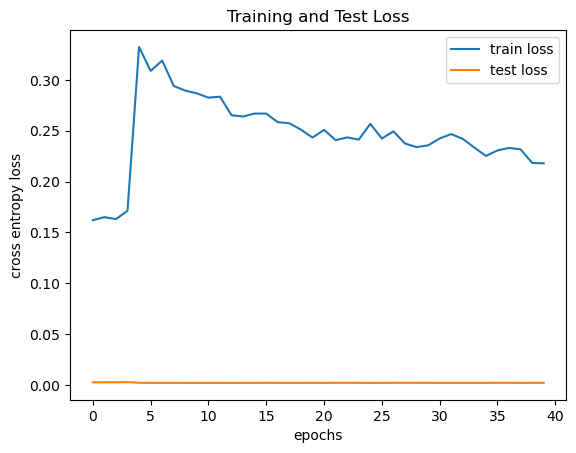

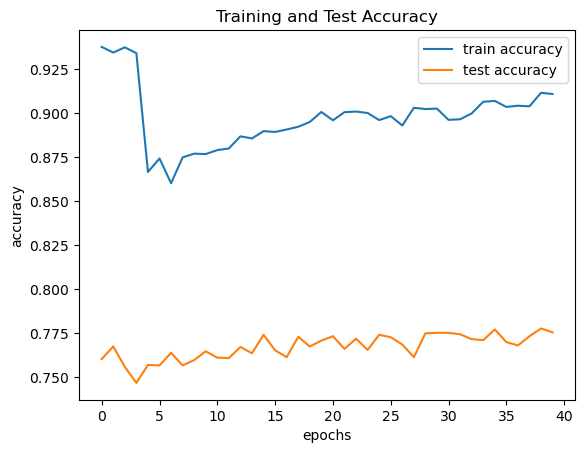

In [60]:
no_epochs = len(train_loss_) 

# Plotting the losses
plt.figure(1)
plt.plot(range(no_epochs), train_loss_, label='train loss')
plt.plot(range(no_epochs), test_loss_, label='test loss')
plt.title('Training and Test Loss')
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.legend()

# Plotting the accuracies
plt.figure(2)
plt.plot(range(no_epochs), train_acc_, label='train accuracy')
plt.plot(range(no_epochs), test_acc_, label='test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

6.Comment on line plots.

In [1]:
# YOUR CODE HERE
answer = '''

Epochs: 40
Best Test Accuracy: 77.75% achieved at epoch 39
Final Test Accuracy: 77.53% at epoch 40
Training Loss: Generally decreasing throughout the epochs, indicating learning.
Test Loss: Relatively stable, showing that the model is not overfitting.

• Training Metrics: The training loss consistently decreased across epochs 5 to 40, starting from 0.3323 to 0.2184, and the training accuracy increased from 86.65% to 91.08%. This indicates that 
the model is effectively learning and adjusting its weights based on the training data. This consistent improvement in training metrics is expected as the model becomes better at fitting the 
training data over successive epochs.

• Testing Metrics & Early Stopping: The testing accuracy increased from 75.68% to a peak of 77.53%. However, the testing loss decreased initially but then started to increase, which might 
suggest the beginning of overfitting. This is also supported by the observation that the training accuracy was continuously rising, but the test accuracy started to plateau. 
The early stopping mechanism proved beneficial by terminating the training process at epoch 40, before the model could overfit further. 

• General Observation: The divergence between training and testing metrics is indicative of a generalization gap. While the training metrics suggest the model is performing better with each 
epoch, the testing metrics show a different story. This disparity can be due to the model starting to memorize the training data and becoming less effective at generalizing to unseen data. 

• Potential Recommendations: The early stopping worked as intended, but if overfitting continues to be an issue, techniques like weight decay using L1 or L2 regularization
might be beneficial. Additionally, gathering more diverse training data, if possible, or employing data augmentation techniques might help in improving the model's generalization capabilities. 

In summary, the model has shown decent learning capabilities. However, there is room for improvement, especially in bridging the gap between training and testing performances.
'''
print(answer)



Epochs: 40
Best Test Accuracy: 77.75% achieved at epoch 39
Final Test Accuracy: 77.53% at epoch 40
Training Loss: Generally decreasing throughout the epochs, indicating learning.
Test Loss: Relatively stable, showing that the model is not overfitting.

• Training Metrics: The training loss consistently decreased across epochs 5 to 40, starting from 0.3323 to 0.2184, and the training accuracy increased from 86.65% to 91.08%. This indicates that 
the model is effectively learning and adjusting its weights based on the training data. This consistent improvement in training metrics is expected as the model becomes better at fitting the 
training data over successive epochs.

• Testing Metrics & Early Stopping: The testing accuracy increased from 75.68% to a peak of 77.53%. However, the testing loss decreased initially but then started to increase, which might 
suggest the beginning of overfitting. This is also supported by the observation that the training accuracy was continuously risin